
# Multiplicative Free Convolution

## Goals of this script: 
- I.   Monte-Carlo for Multiplicative Free Convolutions
- II.  Inverting explicit S-transforms
- III. Application to FreeNN


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

# I. Monte-Carlo for some explicit multiplicative free convolutions.

Recall that the Marchenko-Pastur law is the universal limit for singular values of Gaussian matrices. Following Marchenko and Pastur (1967)
$$ \frac{1}{2 \pi} \frac{\sqrt{(x-l)(r-x)}}{x} dx ,$$
where 
$$r = (1+\sqrt{c})^2$$
$$l = (1-\sqrt{c})^2$$
and $c$ being the scale parameter.

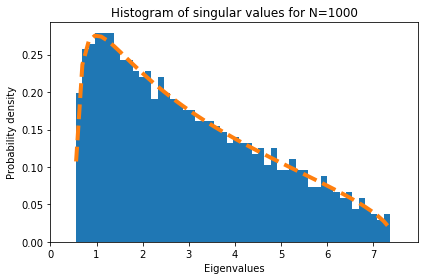

In [3]:
# One MP

N=1000
num_bins=50

c = 3 # MP scale parameter
r = (1+np.sqrt(c))**2 #Right end
l = (1-np.sqrt(c))**2 #Left end

G = np.random.normal( size=(N,c*N) )
W = G.dot( G.transpose() )
W = W/N
diag, U = np.linalg.eig(W)

# Histogram of singular values
fig, ax = plt.subplots()
n, bins, patches = ax.hist(diag, num_bins, density=True)
y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins)
ax.plot(bins, y, '--', linewidth=4)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for N={}'.format(N))
fig.tight_layout()
plt.xlim(0,r+0.5)
plt.show()

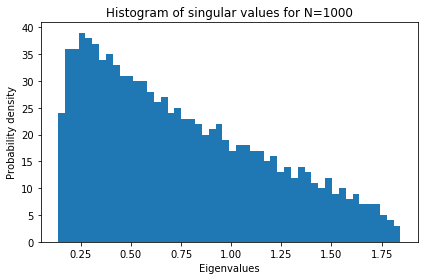

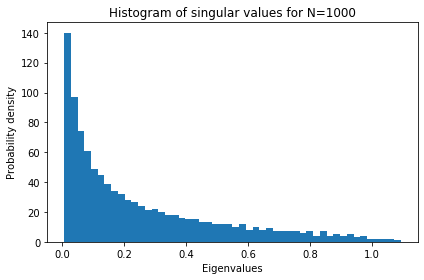

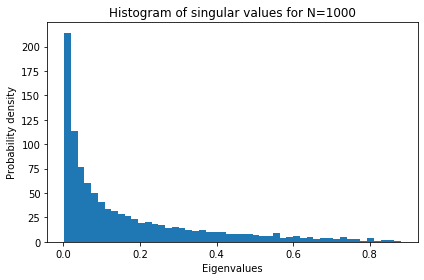

In [4]:
# Multiple ones
scale_params = [3, 0.5, 2]

N=1000
num_bins=50

M = np.identity(N)
for c in scale_params:
    p, q = M.shape
    qq = int(c*q)
    G = np.random.normal( size=(q,qq) )/np.sqrt(q+qq)
    M = M.dot( G )
    W = M.dot( M.transpose() )
    diag, U = np.linalg.eig(W)

    # Histogram of singular values
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(diag, num_bins)
    #y = np.sqrt( (r-bins)*(bins-l) )/(2*np.pi*bins)
    #ax.plot(bins)
    ax.set_xlabel('Eigenvalues')
    ax.set_ylabel('Probability density')
    ax.set_title(r'Histogram of singular values for N={}'.format(N))
    fig.tight_layout()
    plt.show()

# II. Inverting explicit S-transforms
Here we consider the $S$-transforms of Marchenko-Pastur distributions, which are of the form:
$$ S_{W_l}(z) = \frac{1}{\sigma_l} \frac{1}{1+\lambda_l z} \ ,$$
where the $\lambda_i$ are the scale pameters and $\sigma_l^2$ are the variances. For simplicity, we assume for now $\sigma_l^2=1$.

## 1. Basic definitions

In [5]:
# Array of \lambda_l's
scale_params = [3, 1, 0.5]
# Array of \Lambda_l / \lambda_l used for scaling z (Check error in paper!)
w_scaling    = np.cumprod(scale_params)/scale_params

# Compute coefficients of M_inverse (numerator and denominator)
# Conventions:
#   - Coefficients are numpy arrays
#   - Highest degree comes first
#
# Of numerator of M_inverse
roots         = np.append(-1, -1/w_scaling)
leading_coeff = np.prod(w_scaling)
coeff_num     = np.poly( roots ) * leading_coeff
# Of denominator of M_inverse = w
coeff_den     = np.array( [1, 0] )

# Derivatives
coeff_num1    = np.polyder(coeff_num)
coeff_num2    = np.polyder(coeff_num1)
coeff_den1    = np.polyder(coeff_den)
coeff_den2    = np.polyder(coeff_den1)

# Maximal degree
max_degree = max(len(coeff_num1), len(coeff_num2)) - 1

# Test
print(coeff_num)
print(coeff_den)
print( np.polyval(coeff_num, 0) )
print( np.polyval(coeff_den, 0) )
print("")
print("Extending coeffs of second derivative")
print(coeff_num2)
coeff_num2 = np.append( [0.0]*(max_degree+1-len(coeff_num2)), coeff_num2)
print(coeff_num2)
print(coeff_den2)
coeff_den2 = np.append( [0.0]*(max_degree+1-len(coeff_den2)), coeff_den2)
print(coeff_den2)

[ 9. 24. 22.  8.  1.]
[1 0]
1.0
0

Extending coeffs of second derivative
[108. 144.  44.]
[  0. 108. 144.  44.]
[]
[0. 0. 0. 0.]


In [6]:
"""
  Compute Pascal triangle up to size n
  Returns: Numpy matrix with binomial coefficients
  - Matrix represents linear map P(X) \mapsto P(X+1) in the canonical basis
  - Convention is that first columns are the image of monomials of higher degree
"""
def pascal(n):
    # Initialize diagonal and first row
    mat       = np.identity(n, dtype=int)
    mat[:, 0] = 1
    # Loop using the standard binomial recurrence
    for i in range(2,n):
        mat[i, 1:-1] = mat[i-1, 0:-2] + mat[i-1, 1:-1]
    # Satisfy indexing conventions
    mat = np.flip(mat, axis=0)
    mat = mat.transpose()
    mat = np.flip(mat, axis=0)
    return mat

# Test
print("Pascal triangle: \n", pascal(8))
pascal_triangle = pascal(10)
# Test:
print("Taylor expansion of X^3 at 1:")
pascal_triangle = pascal( 4 )
p    = np.zeros( (4, 1), dtype=float)
p[0] = 1.0
print( pascal_triangle.dot( p )[:,0] )

Pascal triangle: 
 [[ 1  0  0  0  0  0  0  0]
 [ 7  1  0  0  0  0  0  0]
 [21  6  1  0  0  0  0  0]
 [35 15  5  1  0  0  0  0]
 [35 20 10  4  1  0  0  0]
 [21 15 10  6  3  1  0  0]
 [ 7  6  5  4  3  2  1  0]
 [ 1  1  1  1  1  1  1  1]]
Taylor expansion of X^3 at 1:
[1. 3. 3. 1.]


In [7]:
# If | P  (X) = \sum c_i X^i = \sum d_i (X-a)^i
#    | P_a(X) = \sum d_i X^i = P(X+a)
# Computes P_a = Taylor expansion of P at a
# which is nothing by the linear map
# P(X) \mapsto P_a(X) = P(X+a)
# X^n \mapsto \sum (n,k) a^k X^{n-k}
def taylor_expand(p, a, pascal_triangle=None):
    #
    degree = len(p)-1
    if pascal_triangle is None:
        pascal_triangle = pascal(degree+1)
    exponents = np.array( range(0, degree+1, 1) )
    powers    = a**exponents
    diag      = np.diag( powers )
    diag_inv  = np.diag( 1/powers )
    weighted_pascal = diag.dot( pascal_triangle )
    weighted_pascal = weighted_pascal.dot( diag_inv )
    return weighted_pascal.dot(p)

# P(x) = (X-1)^3
p = np.array([1,-3, 3, -1]).transpose()
print("Value of p(1): ", np.polyval(p, 1)    )
print("P at 2       : ", taylor_expand(p, 2) )

Value of p(1):  0
P at 2       :  [1. 3. 3. 1.]


## 2. Implementation of Newton-Raphson

Important formulae
$$ m = zg - 1$$
$$ M^{\langle -1 \rangle}(z) g - 1 = z $$

In [8]:
def G(z):
    return (1+M(z))/z

def M_inverse(w):
    return np.polyval(coeff_num,w)/np.polyval(coeff_den,w)

In [9]:
# Classes wrapping functions for NR scheme using Kantorovich theorem for convergence

# Polynomial Wrapper for function m \mapsto f_z(m) 
# We are searching for m such that f_z(m) = 0
# Use case: 
# - m \mapsto f_z(m) is polynomial
# - Away from axis f_z( w=0 ) \approx 0 as z \approx \infty
# - Excellent bound on second derivative via Taylor expansion
class Polynomial_Kantorovich_Wrapper:
    
    # Computes value of f_z(m)
    def f(self, m, z):
        return np.polyval(coeff_num,m)/z - np.polyval(coeff_den,m)

    # Computes value of f_z'(m)
    def f_prime(self, m, z):
        return np.polyval(coeff_num1,m)/z - np.polyval(coeff_den1,m)

    # Computes bound on ball for f_z
    # Input:
    # - (m,z)   : Center
    # - step: Radius
    def f_second_bound(self, m, step, z, ball_max_y):
        p = coeff_num2/z - coeff_den2
        p = taylor_expand( p, m)
        p = abs(p)
        return np.polyval(p, abs(step))


In [10]:
DEFAULT_PRECISION = 1e-8

# Computes the moment generating function M
# Uses a Newton-Raphson iteration for inverting from M^{(-1)}
# WARNING: Guess is not necessarily in basin of attraction, leading to failure
def compute_M_NR( z, function_wrapper, guess=None, error=None):
    if guess is None:
        w = 0
    else:
        w = guess
    #
    if error is None:
        error = DEFAULT_PRECISION
    #
    while True:
        value = function_wrapper.f(w, z)
        if ( abs(value) < error ):
            break
        grad = function_wrapper.f_prime(w, z)
        if ( abs(grad) < error ):
            print("Gradient too small!!")
            print("value: ", value)
            print("grad: ", grad)
            return None
            break
        #Newton-Raphson iteration
        w = w - value/grad
    #
    #print( "Newton-Raphson: ", value, grad)
    return w;

# Computes the Stieljes transform G
# Uses a Newton-Raphson iteration for inverting and finding the g = G(z) such that:
# m = z g - 1
def compute_G_NR( z, function_wrapper, guess=None, error=None):
    if guess is None:
        w = 1/z
    else:
        w = guess
    #
    if error is None:
        error = 1e-8
    #
    w = compute_M_NR( z, function_wrapper, guess=(z*guess-1), error=error)
    return (w+1)/z

# Test for a value in basin of attraction
j = complex(0,1)
z = 1+ j*3
print("z: ", z)
fwrapper = Polynomial_Kantorovich_Wrapper()
w = compute_M_NR( z, function_wrapper=fwrapper )
print("M(z)         = ", w )
print("M_inverse(w) = ", M_inverse(w)   )
print("Error        = ", abs(z-M_inverse(w)) )

z:  (1+3j)
M(z)         =  (-0.10373103867493708-0.1057064855193843j)
M_inverse(w) =  (1.000000000000335+2.99999999999909j)
Error        =  9.696686880155501e-13


In [11]:
def is_in_basin_ZM(z, m, function_wrapper, debug=False):
    value      = function_wrapper.f(m, z)
    derivative = function_wrapper.f_prime(m, z)
    # Compute w value after one step
    step  = -value / derivative
    new_m = m + step
    if debug:
        print("")
        print("Call is_in_basin for z=",z)
        print("value:     ", value)
        print("derivative:", derivative)
        print("m:    ", m)
        print("new_m:", new_m)
        print("Im(m + h_0): ", new_m.imag)
    # Check if new_w in domain
    if new_m.imag >= 0:
       return False
    # Check if NR ball is in domain
    ball_max_y = new_m.imag + abs(step.imag)
    if debug:
        print("Im(m + h_0) + |Im(h_0)|: ", ball_max_y)
    #if ball_max_y >= 0:
    #    return False
    # Compute bound on second derivative
    bound_f_2 = function_wrapper.f_second_bound(new_m, step, z, ball_max_y)
    criterion = abs(step/derivative)*bound_f_2
    if debug:
        print("Kantorovich criterion: ", criterion)
    return criterion < 0.5

def is_in_basin_ZG(z, w, function_wrapper, debug=False):
    return is_in_basin_ZM(z, z*w-1, function_wrapper, debug)

fwrapper = Polynomial_Kantorovich_Wrapper()
z = complex(1,10)
print( is_in_basin_ZG(z, 1/z, function_wrapper = fwrapper, debug=True ) )
z = complex(1,5)
print( is_in_basin_ZG(z, 1/z, function_wrapper = fwrapper, debug=True ) )


Call is_in_basin for z= (1+10j)
value:      (0.009900990099009903-0.09900990099009901j)
derivative: (-0.9207920792079207-0.7920792079207921j)
m:     0j
new_m: (-0.04697986577181209-0.06711409395973154j)
Im(m + h_0):  -0.06711409395973154
Im(m + h_0) + |Im(h_0)|:  0.0
Kantorovich criterion:  0.3343401557838998
True

Call is_in_basin for z= (1+5j)
value:      (0.03846153846153858-0.19230769230769215j)
derivative: (-0.6923076923076923-1.5384615384615374j)
m:     (-1.1102230246251565e-16+2.7755575615628914e-17j)
new_m: (-0.09459459459459463-0.06756756756756763j)
Im(m + h_0):  -0.06756756756756763
Im(m + h_0) + |Im(h_0)|:  2.7755575615628914e-17
Kantorovich criterion:  0.6470977469238436
False


In [12]:
def reset_counters():
    global call_counter_failed_basin
    global call_counter_NR
    call_counter_failed_basin = 0
    call_counter_NR    = 0
    
def compute_G_adaptative( z_objective, proxy=None, debug=False):
    global call_counter_failed_basin
    global call_counter_NR
    j        = complex(0,1)
    fwrapper = Polynomial_Kantorovich_Wrapper()
    #
    # If no proxy is available, find high enough z in basin of attraction and compute associated w
    # This search uses a doubling strategy
    if proxy is None: 
        z = z_objective
        g = 1/z
        while not is_in_basin_ZG(z, g, function_wrapper = fwrapper ):
            call_counter_failed_basin += 1
            z = z + j*z.imag
            g = 1/z
        g = compute_G_NR(z, function_wrapper = fwrapper, guess=g)
        if debug:
            print("Valid z: ", z)
            print("Guess g: ", 1/z)
            print("G(t,z) = ", g )
    else:
        z, g = proxy
        # Useless unless we use higher points for proxy
        # assert(z.real==z_objective.real)
        # assert(z.imag >z_objective.imag)
    if debug:
        print("Proxy (z,g): ", z, g)
    #
    # Starts heading towards the objective z
    while abs(z- z_objective)>0:
        dz = z_objective-z
        while not is_in_basin_ZG(z+dz, g, function_wrapper=fwrapper):
            call_counter_failed_basin += 1
            dz = 0.5*dz
        z = z+dz
        g = compute_G_NR(z, function_wrapper=fwrapper, guess=g)
        call_counter_NR += 1
        if debug:
            print("Valid z: ", z)
            print("G(t,z) = ", g )
    # end while
    return g

j       = complex(0,1)
t       = 1
debug   = False
z_array = 1+ j*np.array([ 1, 0.1, 1e-5, 1e-8, 1e-10])
proxy   = None
for z in z_array:
    print("z: ", z)
    reset_counters()
    g = compute_G_adaptative( z, proxy=proxy)
    proxy = (z, g)
    print("G(z)  = ", g )
    z_check = M_inverse(z*g-1)
    print("M_inv = ", z_check )
    print("Error = ", abs(z_check-z) )
    print("Number of calls to NR: ", call_counter_NR)
    print("Number of calls to attraction basin test: ", call_counter_failed_basin)
    print("")


z:  (1+1j)
G(z)  =  (0.3502415803797093-0.48519493529025604j)
M_inv =  (1.0000000000027038+0.9999999999976256j)
Error =  3.5984263358855466e-12
Number of calls to NR:  36
Number of calls to attraction basin test:  125

z:  (1+0.1j)
G(z)  =  (0.7661277360097638-0.2521002884645004j)
M_inv =  (0.9999999999241715+0.09999999921104492j)
Error =  7.925907365480837e-10
Number of calls to NR:  10
Number of calls to attraction basin test:  23

z:  (1+1e-05j)
G(z)  =  (0.7868712519989131-0.18259990287040512j)
M_inv =  (1.0000000001242126+9.99998514338575e-06j)
Error =  1.2509795748071104e-10
Number of calls to NR:  2
Number of calls to attraction basin test:  0

z:  (1+1e-08j)
G(z)  =  (0.78687264889692-0.18259277892396958j)
M_inv =  (0.9999999991342312+8.011461063866254e-09j)
Error =  2.1688344100565414e-09
Number of calls to NR:  2
Number of calls to attraction basin test:  0

z:  (1+1e-10j)
G(z)  =  (0.7868726504301927-0.1825927717544432j)
M_inv =  (0.9999999999999998+9.999812479121508e-11j)
E

## 3. Computation of the measure (multiple passes)

Pass [1/5], Duration: 1007.8 ms
Number of calls to subroutine:
'Newton-Raphson'  : 2183
'Attraction basin': 6832

Pass [2/5], Duration: 422.7 ms
Number of calls to subroutine:
'Newton-Raphson'  : 951
'Attraction basin': 2770

Pass [3/5], Duration: 97.4 ms
Number of calls to subroutine:
'Newton-Raphson'  : 326
'Attraction basin': 462

Pass [4/5], Duration: 36.2 ms
Number of calls to subroutine:
'Newton-Raphson'  : 218
'Attraction basin': 26

Pass [5/5], Duration: 28.2 ms
Number of calls to subroutine:
'Newton-Raphson'  : 203
'Attraction basin': 3



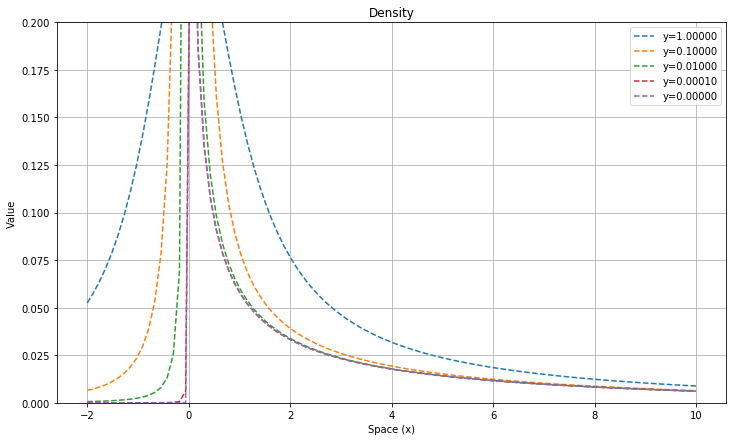

In [13]:
#Imports for 3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


#N: Space mesh
N=100
a=-2
b=10

#Init
space_grid = np.linspace(a, b, N)
dx = (b-a)/N

#Multiple passes for the number of iterations
imaginary_parts = [1.0, 0.1, 0.01, 1e-4, 1e-8]
densities       = []
hilbert_transf  = []
pass_counter    = 0
iter_count      = [ [] for i in space_grid ]
errors1         = [ [] for i in space_grid ]
errors2         = [ [] for i in space_grid ]
choices         = [ [] for i in space_grid ]

j       = complex(0,1)
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
y_proxy = None
guess   = None
G       = np.array( space_grid + complex(0,1) )
for y in imaginary_parts:
    start = time.time()
    reset_counters()
    # Compute
    z = np.array( space_grid + y*complex(0,1) )
    for i in range(N):
        if y_proxy is None:
            G[i] = compute_G_adaptative(z[i], proxy=None)
        else:
            guess = (z[i].real+j*y_proxy, G[i])
            G[i] = compute_G_adaptative(z[i], proxy=guess)
    # Statistics
    pass_counter += 1
    timing        = time.time() - start
    print ('Pass [{}/{}], Duration: {:.1f} ms' 
           .format(pass_counter, len(imaginary_parts), 1000*timing))
    print("Number of calls to subroutine:")
    print("'Newton-Raphson'  :", call_counter_NR)
    print("'Attraction basin':", call_counter_failed_basin)
    print("")
    # Plot
    ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.5f"%y)
    ax.set(xlabel='Space (x)', ylabel='Value',
           title='Density')
    ax.grid()
    #
    y_proxy = y
plt.ylim(0,0.2)
plt.legend()
plt.show()
